In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import csv

In [2]:
df = pd.read_csv("train.csv")
df.head()

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [3]:
def windowed_dataset(series, window_size,batch_size):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window:window.batch(window_size + 1))
    dataset = dataset.map(lambda window:(window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


In [4]:
def draw_graph(history):
  train_loss= history.history['loss']
  train_eva = history.history['root_mean_squared_error']
  valid_loss = history.history['valid_loss']
  valid_eva = history.history['root_mean_squared_error']


In [5]:
def validation_function(series,windowsize):
  series = tf.expand_dims(series, axis=-1)
  predicted_list = []
  for time in range(len(series)-windowsize):
    window_x= series[time:time+windowsize]
    #y = x_valid[start_point+windowsize]
    predicted_y= model.predict(window_x)
    predicted_list.append(predicted_y)
  return predicted_list




In [6]:
df['datetime']=pd.to_datetime(df['date'] + ' ' + df['hour'].astype(str) + ":00:00")

In [7]:
df.set_index('datetime')

,date,hour,demand
datetime,,,
2018-08-18 09:00:00,2018-08-18,9,91
2018-08-18 10:00:00,2018-08-18,10,21
2018-08-18 13:00:00,2018-08-18,13,23
2018-08-18 14:00:00,2018-08-18,14,104
2018-08-18 15:00:00,2018-08-18,15,81
...,...,...,...
2021-02-28 19:00:00,2021-02-28,19,95
2021-02-28 20:00:00,2021-02-28,20,88
2021-02-28 21:00:00,2021-02-28,21,39


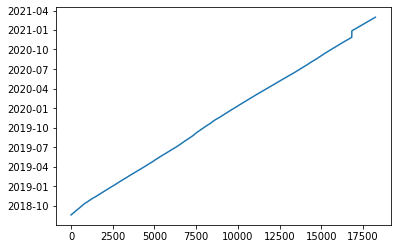

In [8]:
df.datetime.plot()

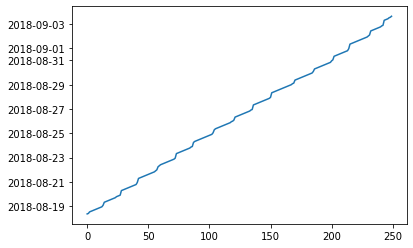

In [9]:
df.datetime[:250].plot()

In [10]:
len(df.datetime)

18247

In [11]:
split_time = 14000
time_train = df.datetime[:split_time]
x_train = df.demand[:split_time]
time_valid = df.datetime[split_time:]
x_valid =  df.demand[split_time:]
window_size = 60
batch_size = 32

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size)


In [13]:
# for feature, label in dataset.take(1):
#  print(feature)
#  print(label)

In [14]:
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs=None):
    if logs.get('root_mean_squared_error') <= 35:
      print("reached the metric")
      print("Its testing time")
      self.model.stop_training=True


In [15]:
# model = tf.keras.models.Sequential([
#  tf.keras.layers.LSTM(32, input_shape=[window_size,1],recurrent_dropout=0.1,dropout = 0.1 ),                               
#  tf.keras.layers.Dense(64,activation="relu"),
#  tf.keras.layers.Dropout(0.2),
# #  tf.keras.layers.Dense(64, activation="relu"),
#  tf.keras.layers.Dense(32, activation="relu"),
#  tf.keras.layers.Dense(1)
# ])

# model = model = tf.keras.models.Sequential([
#  tf.keras.layers.Dense(32,activation='relu',input_shape=[window_size,1]),
#  tf.keras.layers.Dropout(0.2),
#  tf.keras.layers.Dense(16,activation='relu'),
#  tf.keras.layers.Dropout(0.01),
#  tf.keras.layers.Dense(1)
# ])

# model = tf.keras.models.Sequential([
#  tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True),
#  tf.keras.layers.GRU(100),
#  tf.keras.layers.Dense(1)
# ])

model = tf.keras.models.Sequential([
 tf.keras.layers.LSTM(100, input_shape=[window_size, 1], return_sequences=True,recurrent_dropout=0.1,dropout=0.2),
 tf.keras.layers.LSTM(100,dropout=0.2),
 tf.keras.layers.Dense(1)
])

# tf.keras.layers.Bidirectional(
#  tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True,
#  dropout=0.1, recurrent_dropout=0.1)),


In [16]:
mycalback = mycallback()
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(),metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [20]:

history = model.fit(dataset,epochs=50,callbacks=[mycalback])

Epoch 1/50
    117/Unknown - 32s 275ms/step - loss: 1184.4641 - root_mean_squared_error: 34.4160

KeyboardInterrupt: ignored

In [18]:

predicted_value = validation_function(x_valid,window_size)


In [19]:
actual = x_valid[window_size:]
actual = np.array(actual,dtype=np.float32)

forecast = np.array(predicted_value)[:,0,0]


IndexError: ignored

In [ ]:
print(actual.ndim)
print(forecast.ndim)
print(len(actual))
print(len(forecast))
print(actual)

In [ ]:
valid_rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actual, forecast).numpy())

In [ ]:
print(valid_rmse)

In [ ]:
model.save('model2.h5')

In [ ]:
#model = tf.keras.models.load_model('model2.h5')

Creating CSV file with testing data

In [ ]:
def predict_test(seed_series,windowsize):
  seed_series = np.array(tf.expand_dims(seed_series, axis=-1))
  for time in range(10):#7650):
    window_test = seed_series[time:time+windowsize]
    prediction = model.predict(window_test)
    print(prediction.astype(np.float16))
    seed_series = tf.expand_dims(np.append(seed_series,prediction[-1,0].astype(np.float16)),axis = -1)
    print('done')

  return seed_series

  


In [ ]:
with open('test.csv') as f:
  csvreader = csv.reader(f)
  header = [next(csvreader)]
  seed = x_valid[-window_size:]
  test_prediction = np.array(predict_test(seed,window_size))
  rows = []
  for idx,row in enumerate(csvreader):
        rows.append(row)
  rows
  print(rows)

In [ ]:
li = [56,55,23,1,3,23,1,226,25]
li[-3-1:]

In [ ]:
#model = tf.keras.models.load_model('model1.h5')